In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import torchvision
import torch.nn as nn


In [41]:
class Generator(nn.Module):
        def __init__(self,noise_dim):
                super().__init__()
                self.noise_dim=noise_dim
                self.layer1=nn.Sequential(
                        nn.Linear(noise_dim,256*7*7),
                        nn.ReLU(),
                        nn.Unflatten(1,(256,7,7)),
                        nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=2),#12,12 is the output shape
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.ConvTranspose2d(128,1,kernel_size=8,stride=2,padding=1),
                        nn.Tanh()
                )
        def forward(self,x):
                return self.layer1(x)


In [42]:
rand1=t.rand(size=(32,100))
Model=Generator(100)
output=Model(rand1)
print(output.shape)

torch.Size([32, 1, 28, 28])


In [43]:
from torchinfo import summary
summary(Model,
        input_data=rand1,
        col_names=["input_size","output_size","num_params"]

)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Generator                                [32, 100]                 [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 100]                 [32, 1, 28, 28]           --
│    └─Linear: 2-1                       [32, 100]                 [32, 12544]               1,266,944
│    └─ReLU: 2-2                         [32, 12544]               [32, 12544]               --
│    └─Unflatten: 2-3                    [32, 12544]               [32, 256, 7, 7]           --
│    └─ConvTranspose2d: 2-4              [32, 256, 7, 7]           [32, 128, 12, 12]         524,416
│    └─BatchNorm2d: 2-5                  [32, 128, 12, 12]         [32, 128, 12, 12]         256
│    └─ReLU: 2-6                         [32, 128, 12, 12]         [32, 128, 12, 12]         --
│    └─ConvTranspose2d: 2-7              [32, 128, 12, 12]         [32, 1, 28, 28]           8,193
│    └─Tanh: 2-8   

In [44]:
class Discriminator(nn.Module):
        def __init__(self,):
                super().__init__()#input shape =(28,28)
                self.layer1=nn.Conv2d(1,64,kernel_size=6,padding=1,stride=2)#(13,13)
                self.layer2=nn.Sequential(
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2,inplace=True)
                )
                self.layer3=nn.Conv2d(64,128,stride=2,kernel_size=2,padding=1)
                self.layer4=nn.Sequential(
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.4,inplace=True)
                )
                self.layer5=nn.Sequential(
                        nn.Flatten(start_dim=-3,end_dim=-1),
                        nn.Linear(7*7*128,1)
                )
        def forward(self,x):
        
                x=self.layer1(x)
                # print(x.shape)
                x=self.layer2(x)
                # print(x.shape)
                x=self.layer3(x)
                # print(x.shape)
                x=self.layer4(x)
                # print(x.shape)
                x=self.layer5(x)
                # print(x.shape)
                return x


In [45]:
rand2=t.rand(size=(32,1,28,28))
Model_di=Discriminator()
Model_di(rand2)
#uncomment above lines to get shape

tensor([[ 0.0920],
        [-0.2293],
        [-0.5073],
        [-0.1106],
        [ 0.2356],
        [-0.4200],
        [-0.2904],
        [-0.7001],
        [-0.6645],
        [-0.7928],
        [-0.1615],
        [ 0.0258],
        [-0.2801],
        [-0.4639],
        [-0.2364],
        [-0.0517],
        [ 0.3621],
        [-0.3917],
        [-0.6046],
        [-0.8143],
        [-0.5788],
        [-0.2372],
        [ 0.2406],
        [ 0.0370],
        [ 0.1531],
        [-0.2448],
        [-0.1328],
        [ 0.1141],
        [ 0.3300],
        [-0.8919],
        [-0.0313],
        [-0.4783]], grad_fn=<AddmmBackward0>)

In [46]:
noise_dimension=100
criterion=t.nn.BCEWithLogitsLoss()
gen_opti=t.optim.Adam(
        params=Model.parameters(),
        lr=0.0002,
        betas=(0.6,0.99)
)
disc_opti=t.optim.Adam(
        params=Model_di.parameters(),
        lr=0.0002,
        betas=(0.6,0.99)
)

In [47]:
transformation_manual=torchvision.transforms.Compose(
        [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,),(0.5,))

        ]
)

In [48]:
transformation_manual

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [49]:
train_dataset=torchvision.datasets.FashionMNIST(
        train=True,
        download=True,
        root="./data",
        transform=transformation_manual
)
train_data_loader=t.utils.data.DataLoader(dataset=train_dataset,shuffle=True,batch_size=32,num_workers=0,pin_memory=False)

In [50]:
len(train_data_loader)


1875

In [51]:
image,label=train_dataset[0]


9


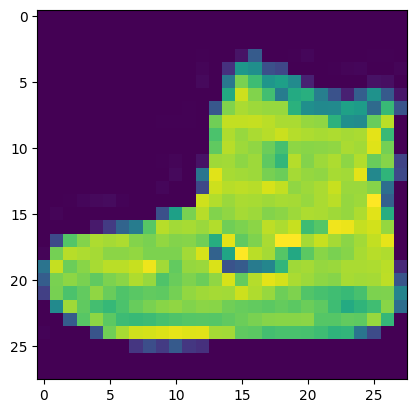

In [52]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze())
print(label)

In [53]:
train_dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [54]:
epochs=20
for epoch in range(epochs):
        for batch in train_data_loader:
                (real_images,y)=batch
                real_labels=t.ones(size=(real_images.size(0),1)).float()
                fake_labels=t.zeros(size=(real_images.size(0),1)).float()
               
                disc_opti.zero_grad()
                real_outputs=Model_di(real_images)
                loss_real=criterion(real_outputs,real_labels)
                
                noise=t.randn(size=(real_images.size(0),100))
                fake_images=Model(noise)
                fake_outputs=Model_di(fake_images.detach())
                loss_fake=criterion(fake_outputs,fake_labels)
                disc_loss=loss_fake+loss_real
                disc_loss.backward()
                disc_opti.step()
                fake_outputs=Model_di(fake_images.detach())
                gen_opti.zero_grad()
                gen_loss=criterion(fake_outputs,real_labels)
                gen_loss.backward()
                gen_opti.step()


                
                


In [56]:
Model_di.layer1.weight.shape

torch.Size([64, 1, 6, 6])

In [57]:
t.save(obj=Model_di.state_dict(),f="disc.pth")
t.save(obj=Model.state_dict(),f="gen.pth")

In [58]:
Model_di.load_state_dict(t.load(f="disc.pth"))

C:\Users\yenug\AppData\Local\Temp\ipykernel_21116\1903813562.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model_di.load_state_dict(t.load(f="disc.pth"))


<All keys matched successfully>

In [84]:
t.manual_seed(21)
output=Model(t.randn(size=(4,100)))
print(output.shape)

torch.Size([4, 1, 28, 28])


In [85]:
values_of_img=t.tensor(output,requires_grad=False)

C:\Users\yenug\AppData\Local\Temp\ipykernel_21116\2634166436.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values_of_img=t.tensor(output,requires_grad=False)


In [86]:
values_of_img.shape

torch.Size([4, 1, 28, 28])

In [87]:
values_of_img[1].squeeze().shape

torch.Size([28, 28])

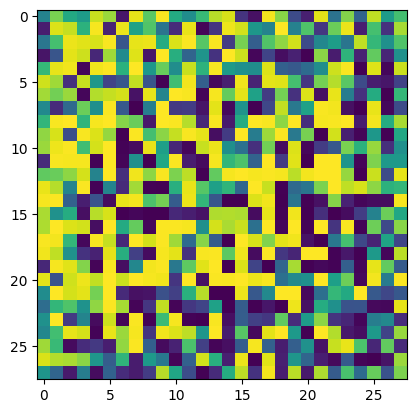

In [90]:
plt.imshow(values_of_img[3].squeeze().numpy())